## SVM Baseline
 - 이 노트북은 SVM(Support Vector Machine)을 활용한 딥페이크 탐지 베이스라인 예시입니다.
 - 베이스라인은 Jupyter Notebook이며 프로젝트 진행 시 Python 스크립트 환경에서 작성하셔도 됩니다.

In [1]:
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

### 1. 데이터 전처리
 - SVM에 입력하기 위해 오디오 데이터를 특징 벡터로 변환합니다.  
 - 여기서는 MFCC, Delta, Delta-Delta 특징을 사용합니다.

In [2]:
# 훈련 데이터 metadata 경로 지정
train_metadata_path = '../2501ml_data/label/train_label.txt'

# 훈련 데이터 경로 지정
train_data_path = '../2501ml_data/train'

# 훈련 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
train_x = []
train_y = []
with open(train_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(train_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 훈련 데이터는 X에 저장
        train_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        train_y.append(label)

In [3]:
print("훈련 데이터의 개수:", len(train_x))
print("훈련 데이터 X의 shape:", train_x[0].shape)

훈련 데이터의 개수: 4000
훈련 데이터 X의 shape: (60,)


In [4]:
# 테스트 데이터 metadata 경로 지정
test_metadata_path = '../2501ml_data/label/test_label.txt'

# 테스트 데이터 경로 지정
test_data_path = '../2501ml_data/test'

# 테스트 데이터의 음성 파일과 레이블을 저장할 리스트 초기화
test_file_names = []
test_x = []
test_y = []
with open(test_metadata_path, 'r') as f:
    # 각 줄을 읽어와서 음성 파일 경로와 레이블을 분리
    for line in f:
        # 각 줄은 화자, 파일 이름, 라벨로 구성되어 있음
        spk, file_name, _, _, label = line.strip().split(' ')
        
        # wav 경로
        wav_path = os.path.join(test_data_path, file_name)

        # MFCC, MFCC delta, MFCC delta-delta 추출
        y, sr = librosa.load(wav_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

        # MFCC, MFCC delta, MFCC delta-delta를 하나의 배열로 결합
        mfcc_combined = np.concatenate((mfcc, mfcc_delta, mfcc_delta2), axis=0)
        # 각 특징의 계수별 평균 계산
        mfcc_mean = np.mean(mfcc_combined, axis=1)

        # 테스트 데이터는 X에 저장
        test_x.append(mfcc_mean)

        # 라벨은 Y에 저장
        test_y.append(label)

        # 테스트 데이터 파일 이름 저장
        test_file_names.append(file_name)

In [5]:
print("테스트 데이터의 개수:", len(test_x))
print("테스트 데이터 X의 shape:", test_x[0].shape)

테스트 데이터의 개수: 2000
테스트 데이터 X의 shape: (60,)


### 2. SVM 훈련
 - SVM 분류기 객체를 생성합니다.
 - 훈련 데이터로 학습하고 테스트 데이터를 통해 정확도를 계산합니다.

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
# 리스트를 numpy 배열로 변환
train_x = np.array(train_x)
train_y = np.array(train_y)

# SVM 모델 정의
svm_model = SVC()

# 모델 훈련
svm_model.fit(train_x, train_y)

SVC()

In [8]:
# 테스트 데이터 리스트를 numpy 배열로 변환
test_x = np.array(test_x)
test_y = np.array(test_y)

# 예측
predictions = svm_model.predict(test_x)
print("예측 결과:", predictions)

예측 결과: ['Real' 'Real' 'Real' ... 'Fake' 'Fake' 'Fake']


Confusion Matrix:


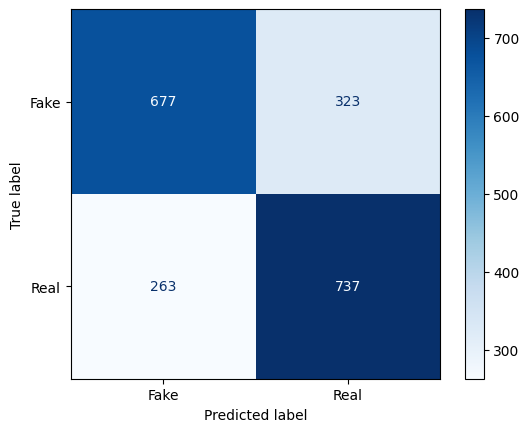

In [9]:
# 혼동행렬 계산
cm = confusion_matrix(test_y, predictions)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### 3. 예측 결과 파일 작성

In [10]:
with open('./team_test_result.txt', 'w') as f:
    for i in range(len(predictions)):
        f.write(f"{test_file_names[i]} {predictions[i]}\n")

In [11]:
!perl ../eval.pl ./team_test_result.txt ../2501ml_data/label/test_label.txt

============ Results Analysis ===========
Test: ./team_test_result.txt
True: ../2501ml_data/label/test_label.txt
Accuracy: 70.70%
Hit: 1414, Total: 2000
